In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


Logistic Regression Accuracy:  0.916
Neural Network Accuracy:  0.9344999999999999


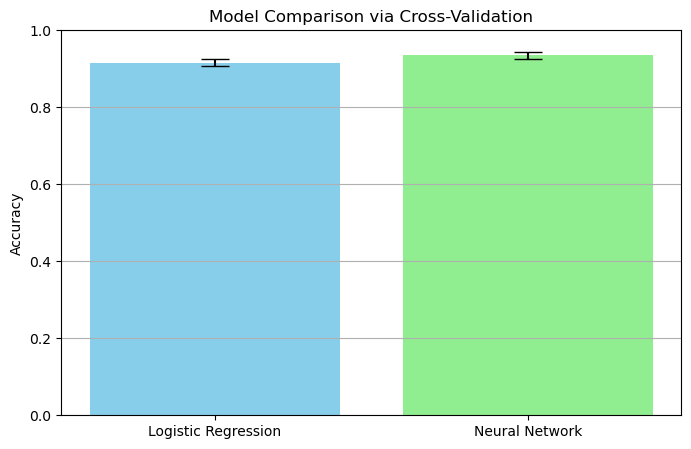

In [3]:
MNIST = pd.read_csv('Numbers.txt', delim_whitespace=True)

X = MNIST.iloc[:, 1:].values
y = MNIST.iloc[:, 0].values

LR_pipe = make_pipeline(StandardScaler(), 
                        LogisticRegression(max_iter=10000, solver = 'lbfgs'))

NN_pipe = make_pipeline(StandardScaler(), 
                        MLPClassifier(hidden_layer_sizes = (1000,) , max_iter=10000, solver='adam', random_state=42))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_score = cross_val_score(LR_pipe, X, y, cv=cv, scoring='accuracy')
NN_score = cross_val_score(NN_pipe, X, y, cv=cv, scoring='accuracy')

print("Logistic Regression Accuracy: ", log_score.mean())
print("Neural Network Accuracy: ", NN_score.mean())    

plt.figure(figsize=(8, 5))
plt.bar(["Logistic Regression", "Neural Network"], 
        [log_score.mean(), NN_score.mean()], 
        yerr=[log_score.std(), NN_score.std()],
        capsize=10, color=['skyblue', 'lightgreen'])

plt.ylabel("Accuracy")
plt.title("Model Comparison via Cross-Validation")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


Logistic Regression Nested CV Accuracy:  0.9209999999999999
Neural Network Nested CV Accuracy:  0.9349999999999999


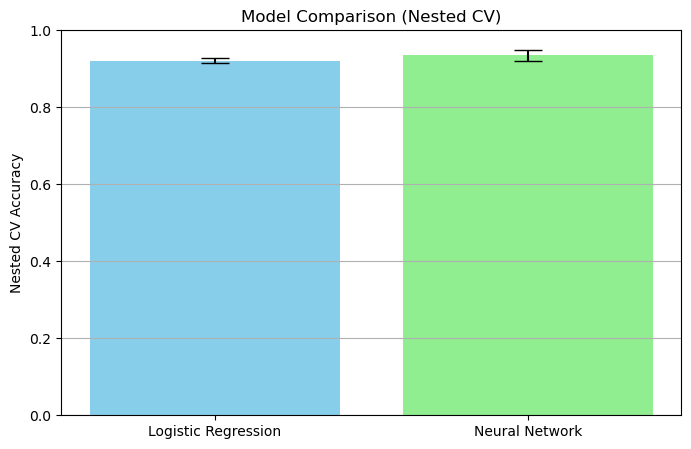

In [4]:
y = MNIST.iloc[:, 0].values
X = MNIST.iloc[:, 1:].values

outer_CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Logitistic Regression
lr_pipe = make_pipeline(StandardScaler(), 
                        LogisticRegression( max_iter=10000, solver = 'lbfgs'))

lr_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv = 3, scoring='accuracy')
lr_nested_scores = cross_val_score(lr_grid_search, X, y, cv=outer_CV, scoring='accuracy')
print("Logistic Regression Nested CV Accuracy: ", lr_nested_scores.mean())


#Neural Network
nn_pipe = make_pipeline(StandardScaler(),MLPClassifier(max_iter=300, solver='adam', random_state=42))

nn_param_grid = {'mlpclassifier__hidden_layer_sizes': [(100,), (200,), (100, 100)],
                 'mlpclassifier__alpha': [0.0001, 0.001, 0.01]}

nn_grid_search = GridSearchCV(nn_pipe, nn_param_grid, cv = 3, scoring='accuracy')
nn_nested_scores = cross_val_score(nn_grid_search, X, y, cv=outer_CV, scoring='accuracy')
print("Neural Network Nested CV Accuracy: ", nn_nested_scores.mean())


plt.figure(figsize=(8, 5))
plt.bar(["Logistic Regression", "Neural Network"],
        [lr_nested_scores.mean(), nn_nested_scores.mean()],
        yerr=[lr_nested_scores.std(), nn_nested_scores.std()],
        capsize=10, color=['skyblue', 'lightgreen'])

plt.ylabel("Nested CV Accuracy")
plt.title("Model Comparison (Nested CV)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


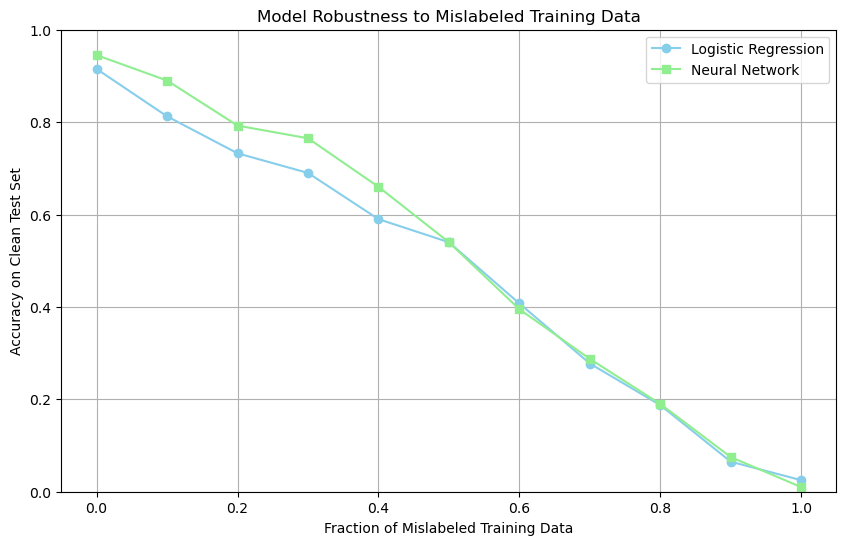

In [6]:
y = MNIST.iloc[:, 0].values
X = MNIST.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def introduce_mislabels (y_train, mislabel_fraction = 0.1, num_classes = 10, random_state = 42):
    np.random.seed(random_state)
    num_samples = len(y_train)
    num_mislabels = int(num_samples * mislabel_fraction)
    
    # Randomly select indices to mislabel
    mislabel_indices = np.random.choice(num_samples, num_mislabels, replace=False)
    
    # Create a copy of y_train to introduce mislabels
    y_train_mislabeled = y_train.copy()
    
    # Introduce mislabels by assigning random classes
    for idx in mislabel_indices:
        new_label = np.random.choice([i for i in range(num_classes) if i != y_train[idx]])
        y_train_mislabeled[idx] = new_label

    return y_train_mislabeled


LR_pipe = make_pipeline(StandardScaler(), 
                        LogisticRegression(max_iter=10000, solver = 'lbfgs'))

NN_pipe = make_pipeline(StandardScaler(),
                        MLPClassifier(hidden_layer_sizes = (1000,) , max_iter=10000, solver='adam', random_state=42))

mislabels_fraction = np.linspace(0, 1, 11)
lr_accuracy = []
nn_accuracy = []

for frac in mislabels_fraction:
    y_train_noisy = introduce_mislabels(y_train, mislabel_fraction=frac)

    LR_pipe.fit(X_train, y_train_noisy)
    LR_accuarcy = accuracy_score(y_test, LR_pipe.predict(X_test))
    lr_accuracy.append(LR_accuarcy)

    NN_pipe.fit(X_train, y_train_noisy)
    NN_accuracy = accuracy_score(y_test, NN_pipe.predict(X_test))
    nn_accuracy.append(NN_accuracy)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mislabels_fraction, lr_accuracy, marker='o', label='Logistic Regression', color='skyblue')
plt.plot(mislabels_fraction, nn_accuracy, marker='s', label='Neural Network', color='lightgreen')

plt.xlabel("Fraction of Mislabeled Training Data")
plt.ylabel("Accuracy on Clean Test Set")
plt.title("Model Robustness to Mislabeled Training Data")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

Fraction of mislabels: 0.0
Fraction of mislabels: 0.1
Fraction of mislabels: 0.2
Fraction of mislabels: 0.30000000000000004
Fraction of mislabels: 0.4
Fraction of mislabels: 0.5
Fraction of mislabels: 0.6000000000000001
Fraction of mislabels: 0.7000000000000001
Fraction of mislabels: 0.8
Fraction of mislabels: 0.9
Fraction of mislabels: 1.0


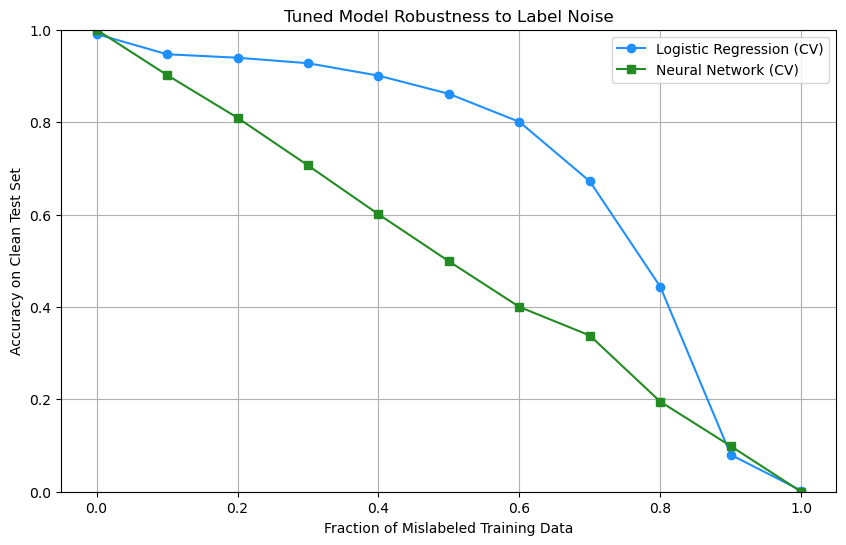

In [15]:
import numpy as np

mislabels_fraction = np.linspace(0, 1, 11)

lr_cv_accuracy = []
nn_cv_accuracy = []

lr_param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10]}
nn_param_grid = {'mlpclassifier__hidden_layer_sizes': [(100,), (100, 100)],
                    'mlpclassifier__alpha': [0.0001, 0.001]}

for frac in mislabels_fraction:
    print(f"Fraction of mislabels: {frac}")
    y_train_noisy = introduce_mislabels(y_train, mislabel_fraction=frac)

    lr_pipe = make_pipeline(StandardScaler(), 
                            LogisticRegression(max_iter=10000, solver = 'lbfgs'))
    lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv=3, scoring='accuracy')
    lr_grid_search.fit(X_train, y_train_noisy)
    lr_best_model = lr_grid_search.best_estimator_
    lr_cv_acc = accuracy_score(y_train, lr_best_model.predict(X_train))
    lr_cv_accuracy.append(lr_cv_acc)

    nn_pipe = make_pipeline(StandardScaler(),
                            MLPClassifier(max_iter=1000, solver='adam', random_state=42))
    nn_grid_search = GridSearchCV(nn_pipe, nn_param_grid, cv=3, scoring='accuracy')
    nn_grid_search.fit(X_train, y_train_noisy)
    nn_best_model = nn_grid_search.best_estimator_
    nn_cv_acc = accuracy_score(y_train, nn_best_model.predict(X_train))
    nn_cv_accuracy.append(nn_cv_acc)


plt.figure(figsize=(10, 6))
plt.plot(mislabels_fraction, lr_cv_accuracy, marker='o', label='Logistic Regression (CV)', color='dodgerblue')
plt.plot(mislabels_fraction, nn_cv_accuracy, marker='s', label='Neural Network (CV)', color='forestgreen')

plt.xlabel("Fraction of Mislabeled Training Data")
plt.ylabel("Accuracy on Clean Test Set")
plt.title("Tuned Model Robustness to Label Noise")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

